In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json # to read credentials

# Regex stuff
import re

# PDF stuff
import PyPDF2 as pypdf

# TRINO stuff
import trino

# Datetime stuff
from datetime import datetime

# GSheet Stuff
from gspread_pandas import Spread

# Computer Stuff
import os

# Dates stuff
from datetime import datetime, date, timedelta

# Levenshtein Distance stuff
from textdistance import levenshtein

# N-Grams stuff
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Regex stuff
import re

# Cross Validation stuff
from sklearn.model_selection import train_test_split

# ROC Curves stuff
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, precision_recall_curve

# Pandas SQL stuff
from pandasql import sqldf

# Continous A/B test or cluster A/B test stuff
from cluster_experiments import PowerAnalysis

# Setting random_state
import random

# ggplot2 in Python
import plotnine as pn

# More stuff
import pathlib
import dotenv
from typing import Optional, List

# A/B Test Stuff
from mizani.breaks import date_breaks
from statsmodels.stats.proportion import proportion_confint, proportion_effectsize
from statsmodels.stats.power import tt_ind_solve_power

In [1]:
query='''

-- First picker part

SELECT 
       -- CHECKOUT TEMPLATE RECEIVED DATA
       DATE(DATE_TRUNC('DAY', ctr.creation_time)) AS ctr_date
       , ctr.country AS ctr_country
       , ctr.dynamic_session_id AS ctr_dynamic_session_id
       , ctr.available_payment_methods AS ctr_available_payment_methods
       , ctr.payment_method AS ctr_payment_method
       , ctr.platform AS ctr_platform
       -- CHECKOUT ORDER CREATED DATA
       , coc.country AS coc_country
       , coc.dynamic_session_id AS coc_dynamic_session_id
       , coc.payment_method AS coc_payment_method
       , coc.platform AS coc_platform

    FROM (SELECT DISTINCT * FROM delta.customer_behaviour_odp.enriched_screen_view__checkout_template_received_v3) ctr
            LEFT JOIN (SELECT DISTINCT * FROM delta.customer_behaviour_odp.enriched_backend_event__checkout_order_created_v3) coc ON LOWER(coc.checkout_session_id)=LOWER(ctr.checkout_session_id)
    WHERE DATE(ctr.p_creation_date)>=DATE(date_add('day', -40, current_date))
;    
    
-- Second picker part

SELECT 
       -- CHECKOUT TEMPLATE RECEIVED DATA
       DATE(DATE_TRUNC('DAY', ctr.creation_time)) AS ctr_date
       , ctr.country AS ctr_country
       , ctr.dynamic_session_id AS ctr_dynamic_session_id
       , ctr.available_payment_methods AS ctr_available_payment_methods
       , ctr.payment_method AS ctr_payment_method
       , ctr.platform AS ctr_platform
       -- CHECKOUT ORDER CREATED DATA
       , coc.country AS coc_country
       , coc.dynamic_session_id AS coc_dynamic_session_id
       , coc.payment_method AS coc_payment_method
       , coc.platform AS coc_platform

    FROM (SELECT DISTINCT * FROM delta.customer_behaviour_odp.enriched_screen_view__checkout_template_received_v3) ctr
            LEFT JOIN (SELECT DISTINCT * FROM delta.customer_behaviour_odp.enriched_backend_event__checkout_order_created_v3) coc ON LOWER(coc.checkout_session_id)=LOWER(ctr.checkout_session_id)
    WHERE DATE(ctr.p_creation_date)>=DATE('2023-11-25')
                AND DATE(ctr.p_creation_date)<DATE('2023-12-17')
;   
    
    

'''

In [2]:
df2=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_40_days.csv') #Downloaded csv data used

In [3]:
df3=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_20_days.csv') #Downloaded csv data used

In [4]:
# Join df that were not posible to query due to large amount of information
df=pd.concat([df2, df3])

In [5]:
del df2
del df3

In [6]:
df.dtypes

ctr_date                         object
ctr_country                      object
ctr_dynamic_session_id           object
ctr_available_payment_methods    object
ctr_payment_method               object
ctr_platform                     object
coc_country                      object
coc_dynamic_session_id           object
coc_payment_method               object
coc_platform                     object
dtype: object

In [7]:
agg = df.groupby(
    ['ctr_date','ctr_country'],
    as_index=False
    ).agg(
    count_events = ('coc_dynamic_session_id', 'nunique')
    )

entries = df.groupby(
    ['ctr_date','ctr_country'], 
    as_index=False
    ).agg(count_starts = ('ctr_dynamic_session_id', 'nunique'))

agg = agg.merge(entries, on=['ctr_date','ctr_country'], how='left')
agg['pctn'] = agg['count_events'] / agg['count_starts']
grouped=agg.copy()

In [14]:
# Checkout Template screen to Order Created rate confidence intervals
grouped['template_order_rate_lower'], grouped['template_order_rate_upper'] = zip(*grouped.apply(
        lambda x: proportion_confint(x.count_events, x.count_starts),
        axis=1
        )
    )

# PV screen to verified rate
grouped['template_order_rate_rate']=grouped.apply(
        lambda x: x.count_events/x.count_starts,
        axis=1
        )

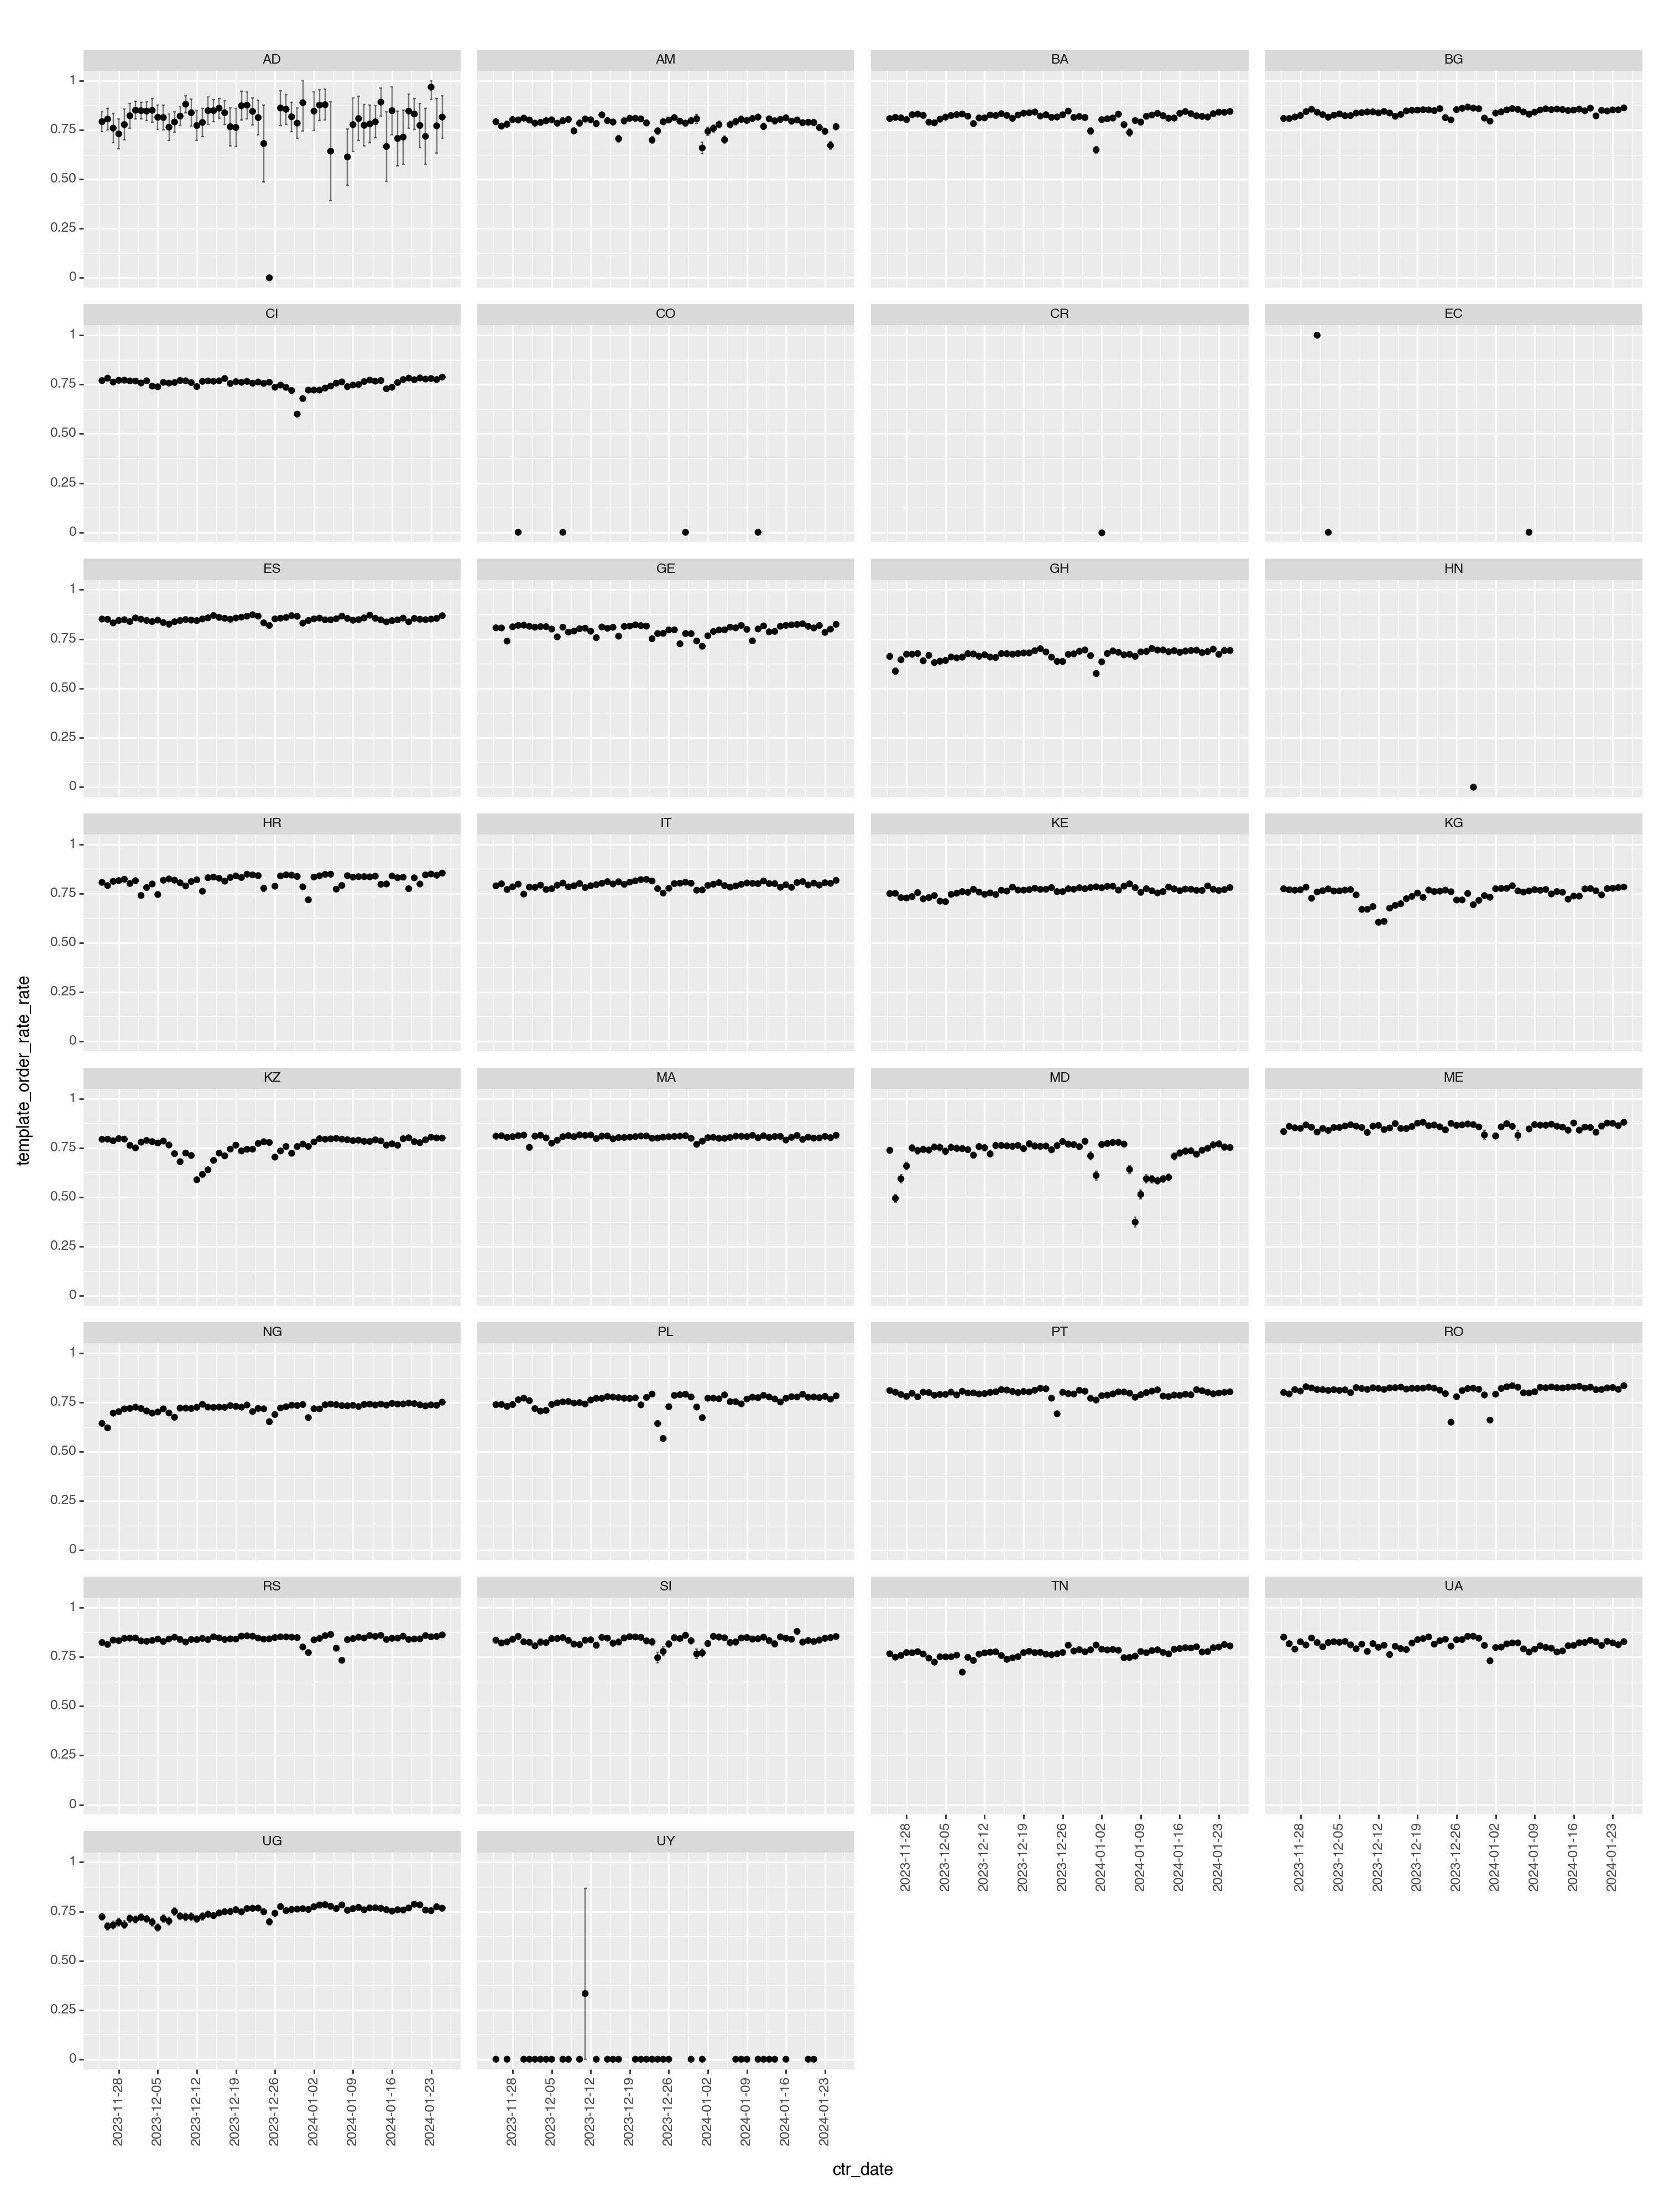

<Figure Size: (1500 x 2000)>

In [16]:
# Historic Checkout Template screen to Order Created rate behaviour
(
    pn.ggplot(grouped, pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

In [24]:
SWE = ['AD', 'ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

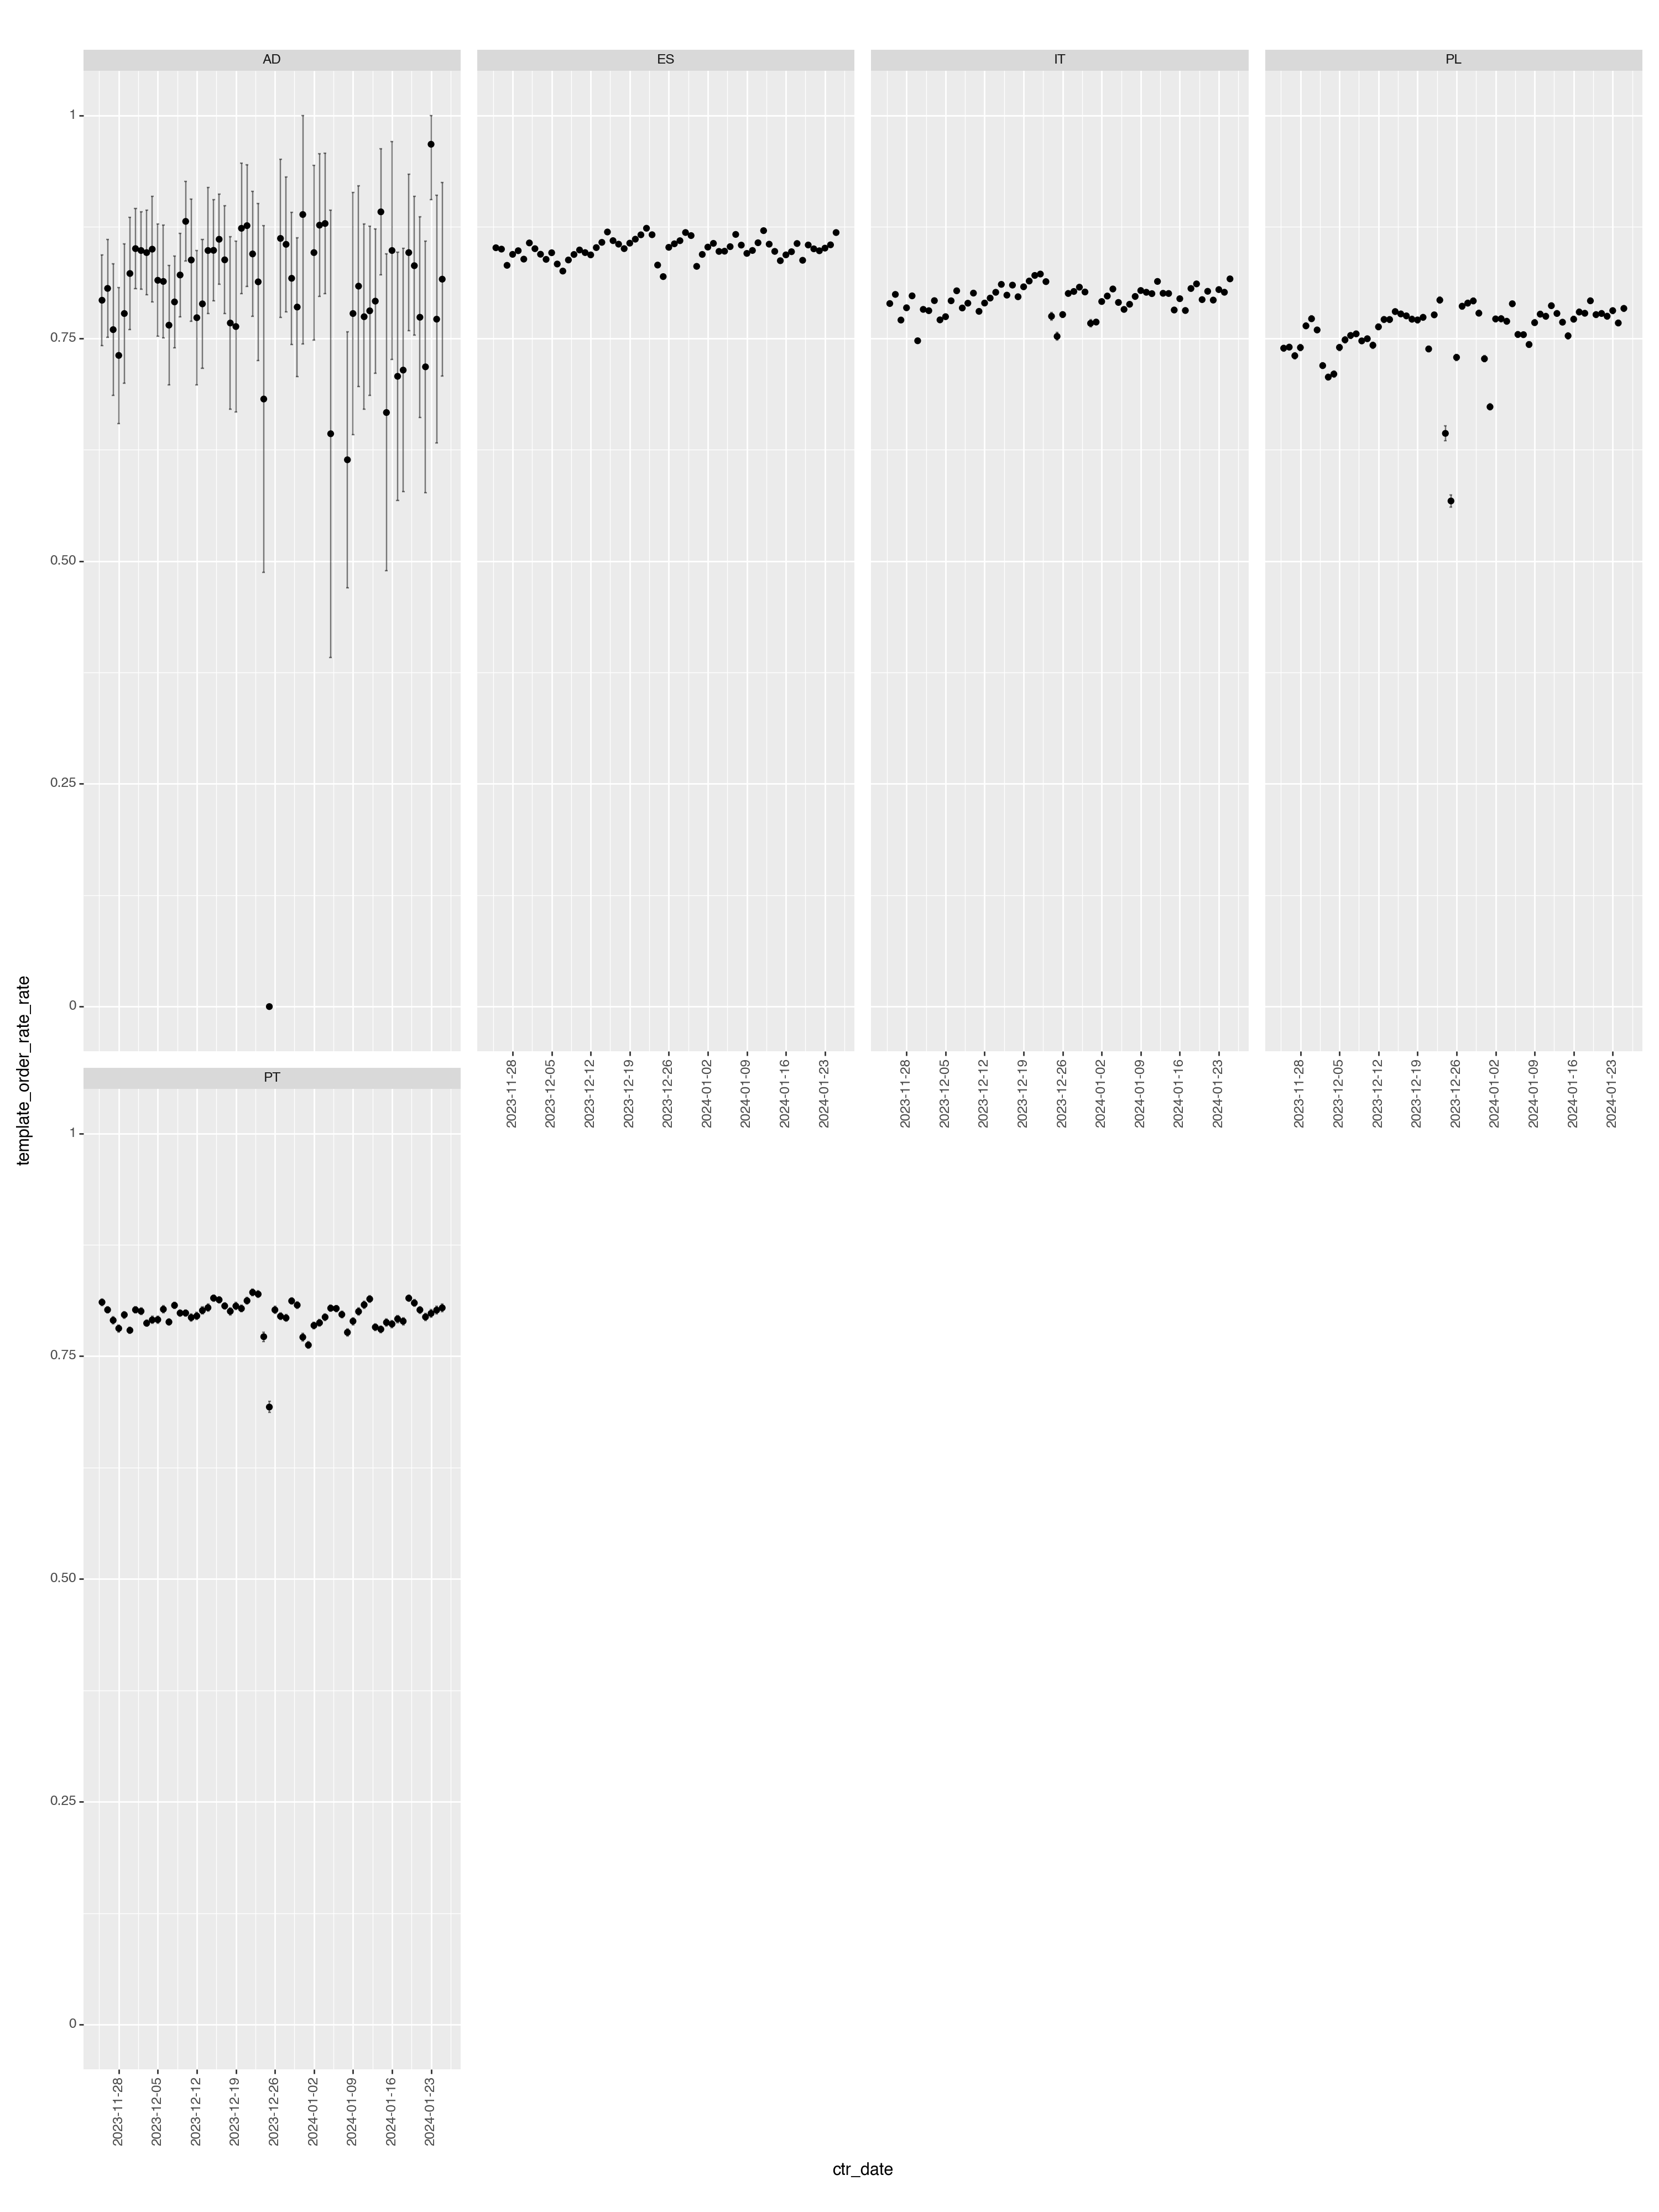

<Figure Size: (1500 x 2000)>

In [25]:
# Historic screen to verified rate behaviour
(
    pn.ggplot(grouped.query(SWE_string), pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

# Sample Size

In [37]:
SWE = ['AD','ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

In [38]:
ALPHA = 0.05 # -> 0.95^2~0.90125 
POWER = 0.80

exp_design = grouped.query(SWE_string).groupby(
    'ctr_country',
    as_index=False
    ).agg(
        total = ("count_starts", "sum"),
        succesful = ("count_events", "sum"),
        avg_daily_events = ("count_starts", "mean")
    )

exp_design['template_order_rate_rate'] = exp_design['succesful']/exp_design['total']

exp_design['template_order_rate_lower'], exp_design['template_order_rate_upper'] = zip(*exp_design.apply(
        lambda x: proportion_confint(x.succesful, x.total),
        axis=1
        )
    )

In [39]:
def cartesian_product(d):
    index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    return pd.DataFrame(index=index).reset_index()

In [40]:
# A range of MDEs (relative increases)
#mdes
mdes = cartesian_product({
    'ctr_country': exp_design['ctr_country'].unique().tolist(),
    'mde':  np.linspace(0.01, 0.05, 16, endpoint=True)
})

In [41]:
exp_design = exp_design.merge(mdes, how='outer')

In [42]:
exp_design['prop_effsize'] = exp_design.apply(
    lambda x: proportion_effectsize((1+x.mde)*x.template_order_rate_rate, x.template_order_rate_rate), 
    axis=1
)

In [43]:
exp_design['ratio'] = 1 #-> 50%-50% split to reduce experiment duration

calc_nobs_var = lambda x: tt_ind_solve_power(
    effect_size=x.prop_effsize, 
    ratio=x.ratio, 
    alpha=ALPHA, 
    power=POWER, 
    alternative='two-sided'
)

exp_design['nobs_CG'] = 1.00*exp_design.apply(calc_nobs_var, axis=1).astype(float)
exp_design['nobs_var'] = exp_design['nobs_CG'] * exp_design['ratio']
exp_design['nobs_total'] = exp_design['nobs_CG'] + exp_design['nobs_var']

In [44]:
exp_design['exp_days'] = exp_design['nobs_total']/exp_design['avg_daily_events']

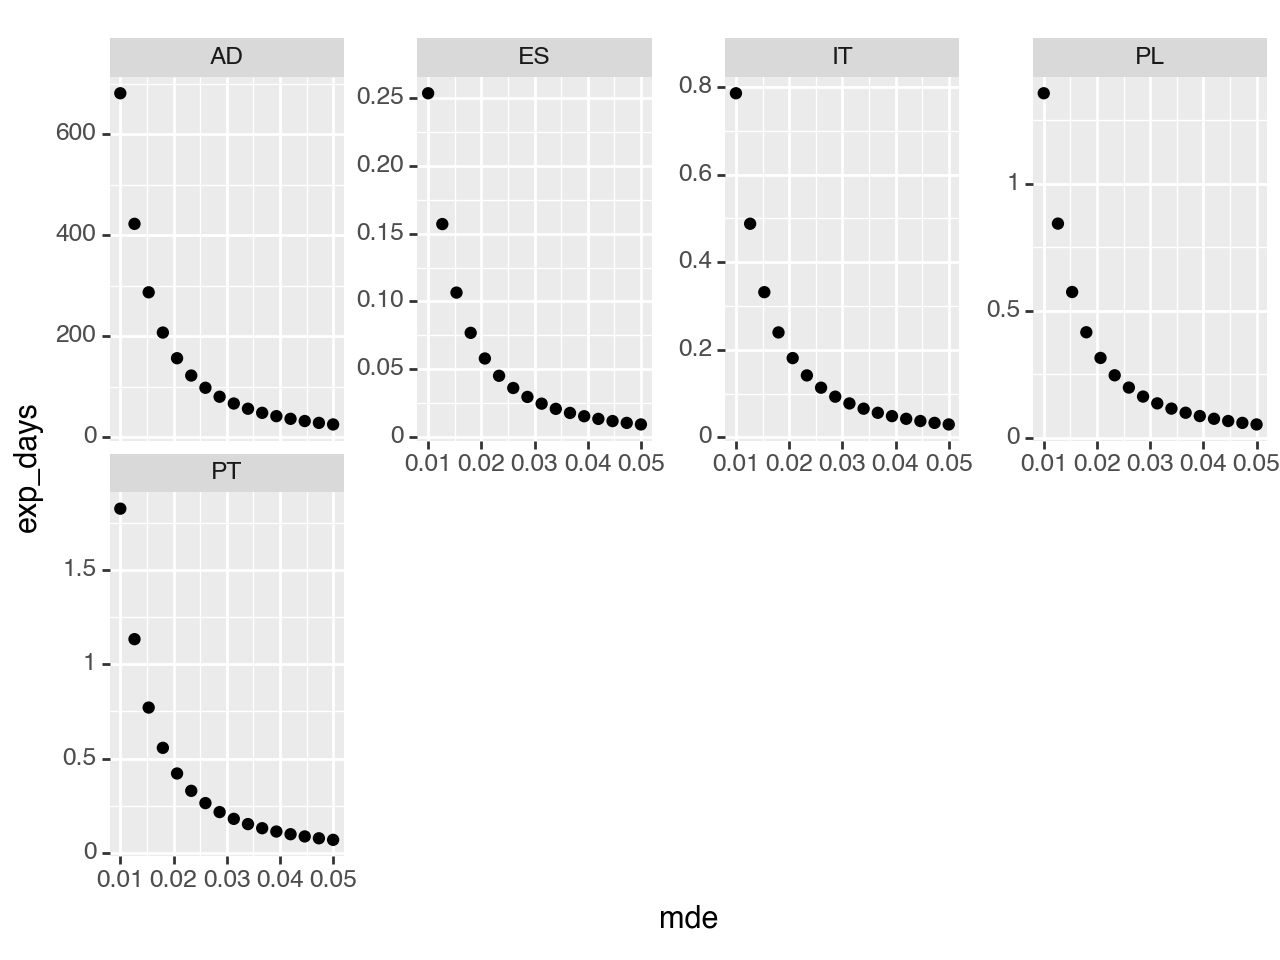

<Figure Size: (640 x 480)>

In [45]:
# Experiment duration plots to detect an MDE
(
    pn.ggplot(exp_design, pn.aes(x='mde', y='exp_days', group='ctr_country')) +
    pn.geom_point() +
    pn.facet_wrap('~ctr_country', scales="free_y", ncol=4) 
    #+
    #pn.theme(figure_size=(15,20))
)

In [47]:
agg.sum()

ctr_date        2023-11-252023-11-252023-11-252023-11-252023-1...
ctr_country     ADAMBABGCIESGEGHHRITKEKGKZMAMDMENGPLPTRORSSITN...
count_events                                             40574510
count_starts                                             50180889
pctn                                                   1213.58853
dtype: object

# Now we need to subset to 5% the total traffic we are going to use in real life

In [48]:
import gc

# Now, to delete all DataFrames:
for name in dir():
    if isinstance(globals()[name], pd.DataFrame):
        del globals()[name]

# Call the garbage collector to free up memory
gc.collect()

2516

In [49]:
def sample_daily_events(df, percentage, random_state=None):
    # Ensure the percentage is a float between 0 and 1
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1")
    sampled_df = df.groupby('ctr_date').apply(
        lambda x: x.sample(frac=percentage, replace=False, random_state=random_state))
    sampled_df = sampled_df.reset_index(drop=True)
    return sampled_df

In [50]:
df2=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_40_days.csv') #Downloaded csv data used

In [51]:
sampled_events = sample_daily_events(df2, 0.05, 1)

In [52]:
del df2

In [53]:
df3=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_20_days.csv') #Downloaded csv data used

In [54]:
sampled_events3= sample_daily_events(df3, 0.05, 1)

In [55]:
del df3

In [56]:
sampled_events['ctr_date'].min()

'2023-12-17'

In [57]:
sampled_events['ctr_date'].max()

'2024-01-25'

In [58]:
sampled_events3['ctr_date'].min()

'2023-11-25'

In [59]:
sampled_events3['ctr_date'].max()

'2023-12-16'

In [60]:
# Join df that were not posible to query due to large amount of information
sampled_events=pd.concat([sampled_events3, sampled_events])

In [ ]:
# Tracy suggest if I do not seasonality in data I can sample them out without having specific 5% per day, I think is not correct because data would be unbalanced in % terms I think

In [62]:
sampled_events

,ctr_date,ctr_country,ctr_dynamic_session_id,ctr_available_payment_methods,ctr_payment_method,ctr_platform,coc_country,coc_dynamic_session_id,coc_payment_method,coc_platform
0,2023-11-25,IT,542DF26E-BA6B-4058-A66B-E7A80FCC63C8,"CreditCard,CreditCard,ApplePay,Cash",CreditCard,IOS,NaN,NaN,NaN,NaN
1,2023-11-25,PT,d52b15ad-6032-4cde-8e64-a92df60ac167,"null,MB WAY,Cash",GooglePay,Android,NaN,NaN,NaN,NaN
2,2023-11-25,RO,8EAAA989-0332-4DE3-BF1D-0456E1A3051F,"ApplePay,Cash",NaN,IOS,RO,8EAAA989-0332-4DE3-BF1D-0456E1A3051F,Cash,IOS
3,2023-11-25,RO,ec0a13f5-ad5f-4f00-b26c-c75e6fe5a5fa,"GooglePay,Cash",Cash,Android,RO,ec0a13f5-ad5f-4f00-b26c-c75e6fe5a5fa,Cash,ANDROID
4,2023-11-25,PL,A227D4C0-61F5-4D9C-92BD-51B1F5F2642F,"null,BLIK,Cash",ApplePay,IOS,PL,A227D4C0-61F5-4D9C-92BD-51B1F5F2642F,CreditCard,IOS
...,...,...,...,...,...,...,...,...,...,...
4872881,2024-01-25,PT,0f1a2665-4e52-43b0-b665-65dc132f467b,"GooglePay,MB WAY,Cash",NaN,Android,PT,0f1a2665-4e52-43b0-b665-65dc132f467b,Cash,ANDROID
4872882,2024-01-25,BG,8A28D50B-5662-4A14-BDE2-2704EDE2A04C,NaN,ApplePay,IOS,BG,8A28D50B-5662-4A14-BDE2-2704EDE2A04C,ApplePay,IOS
4872883,2024-01-25,GE,2E64664B-7A95-4DEE-908D-788784FFB0BC,"CreditCard,ApplePay,Cash",CreditCard,IOS,GE,2E64664B-7A95-4DEE-908D-788784FFB0BC,CreditCard,IOS
4872884,2024-01-25,PT,0C28F91E-6E50-4C9E-B937-3EE602016847,"CreditCard,CreditCard,CreditCard,CreditCard,Cr...",ApplePay,IOS,PT,0C28F91E-6E50-4C9E-B937-3EE602016847,ApplePay,IOS


In [65]:
agg2 = sampled_events.groupby(
    ['ctr_date', 'ctr_country'],
    as_index=False
    ).agg(
    count_events = ('coc_dynamic_session_id', 'nunique')
    )

# entries = data[data['pve_first_step'] == 'STARTED']
# How many "STARTS" are done It starts but does not matter where it ends
entries2 = sampled_events.groupby(
    ['ctr_date','ctr_country'], 
    as_index=False
    ).agg(count_starts = ('ctr_dynamic_session_id', 'nunique'))

# Join total starts to their segmentation is total vs individual group that are part of those starts.
agg2 = agg2.merge(entries2, on=['ctr_date','ctr_country'], how='left')

In [76]:
agg2.count_events.sum()/agg2.count_starts.sum()

0.6038534312982992

In [77]:
grouped=agg2.copy()

In [78]:
# Checkout Template screen to Order Created rate confidence intervals
grouped['template_order_rate_lower'], grouped['template_order_rate_upper'] = zip(*grouped.apply(
        lambda x: proportion_confint(x.count_events, x.count_starts),
        axis=1
        )
    )

# PV screen to verified rate
grouped['template_order_rate_rate']=grouped.apply(
        lambda x: x.count_events/x.count_starts,
        axis=1
        )

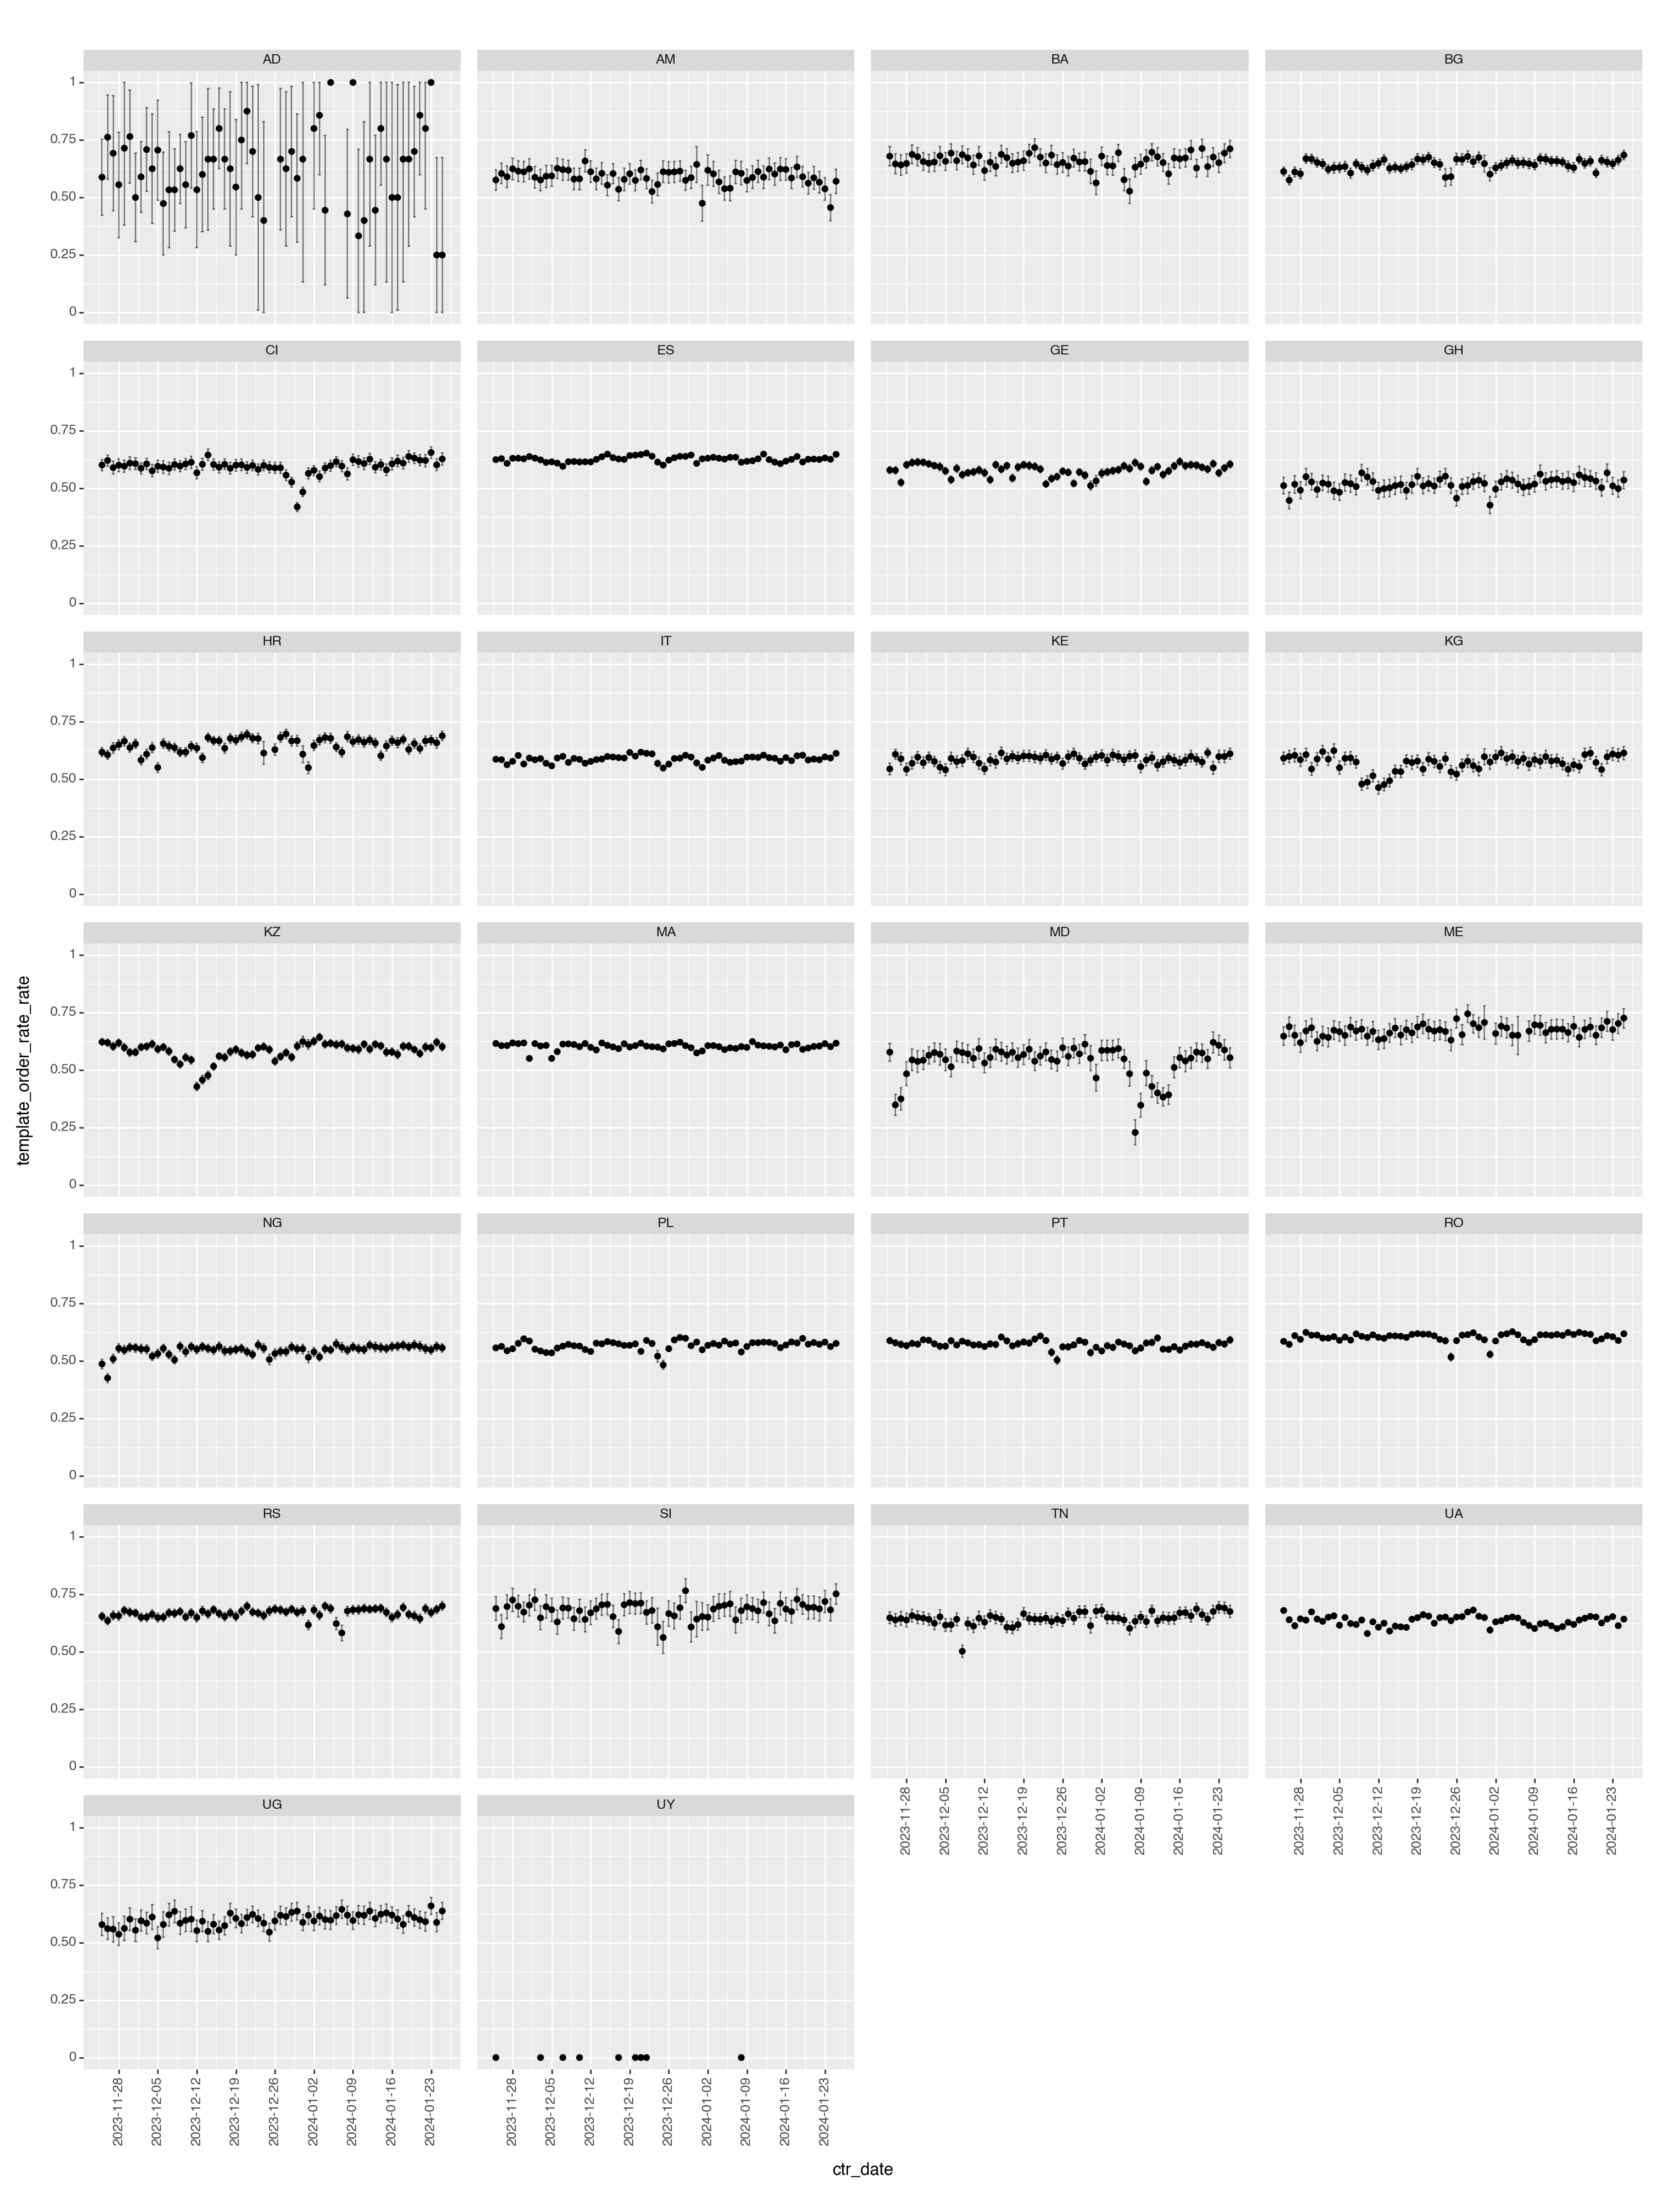

<Figure Size: (1500 x 2000)>

In [79]:
# Historic Checkout Template screen to Order Created rate behaviour
(
    pn.ggplot(grouped, pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

In [84]:
SWE = ['AD', 'ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

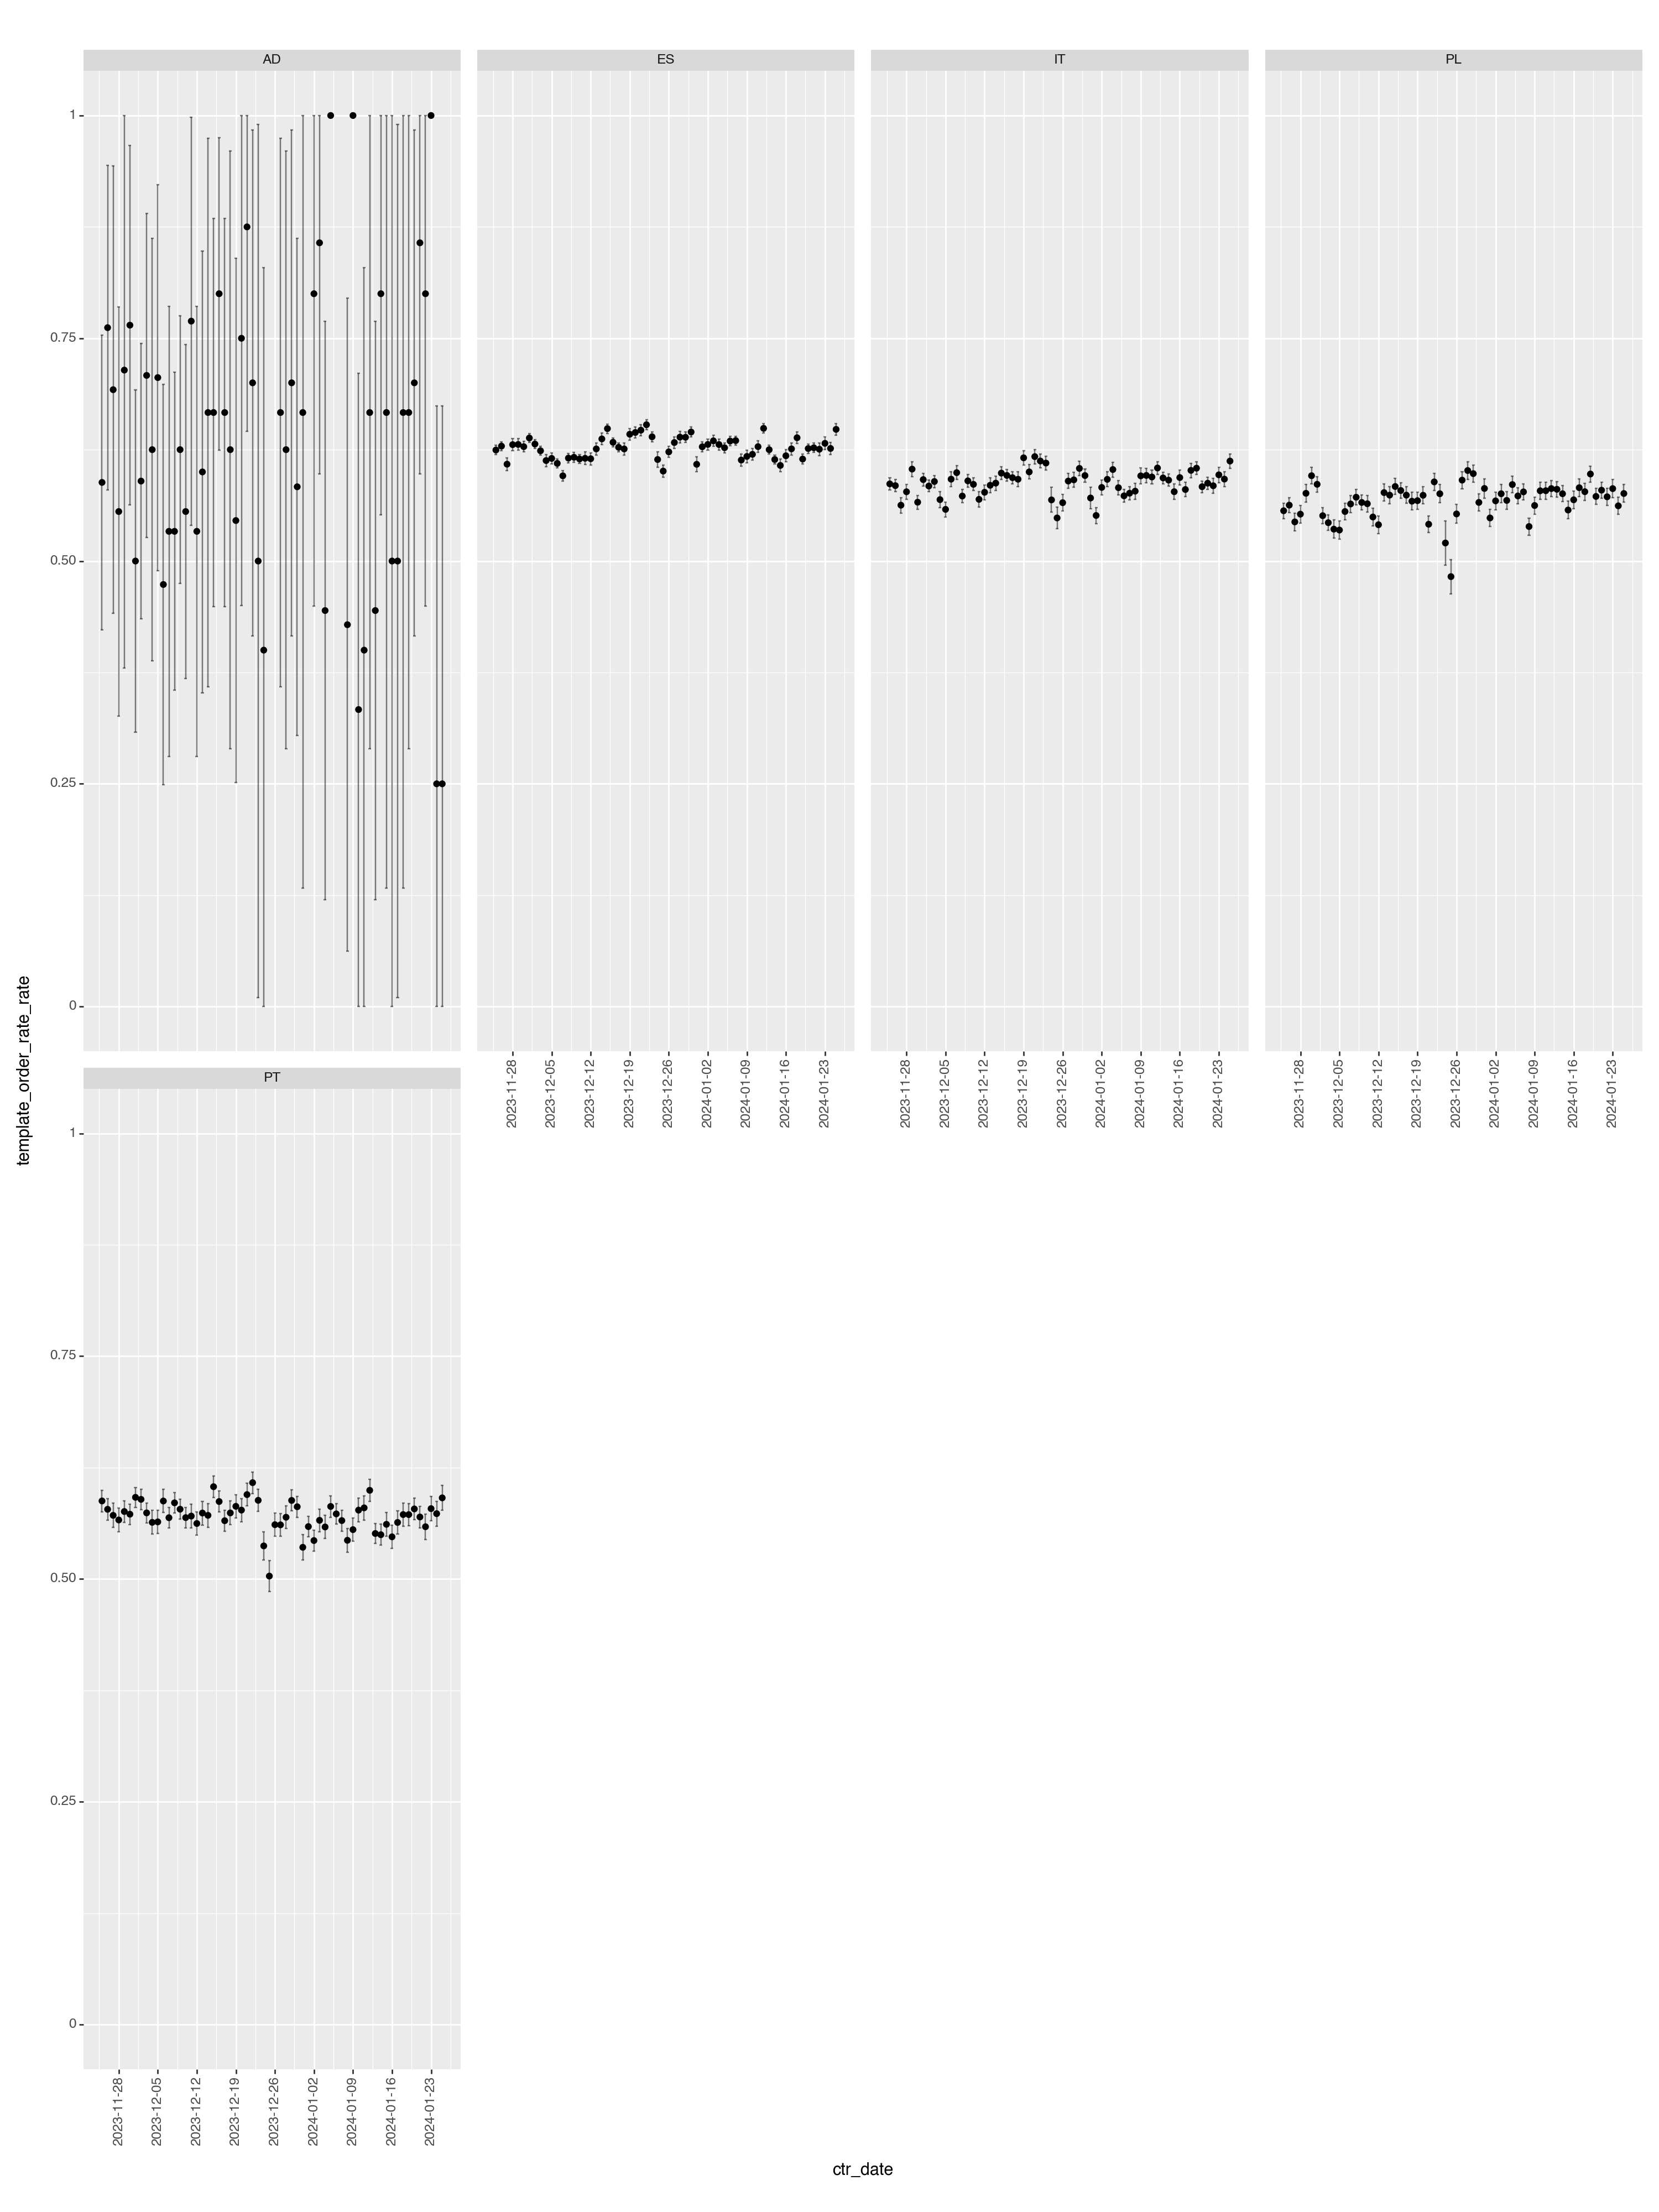

<Figure Size: (1500 x 2000)>

In [85]:
# Historic screen to verified rate behaviour
(
    pn.ggplot(grouped.query(SWE_string), pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

# Sample Size

In [86]:
SWE = ['AD','ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

In [87]:
ALPHA = 0.05 # -> 0.95^2~0.90125 
POWER = 0.80

exp_design = grouped.query(SWE_string).groupby(
    'ctr_country',
    as_index=False
    ).agg(
        total = ("count_starts", "sum"),
        succesful = ("count_events", "sum"),
        avg_daily_events = ("count_starts", "mean")
    )

exp_design['template_order_rate_rate'] = exp_design['succesful']/exp_design['total']

exp_design['template_order_rate_lower'], exp_design['template_order_rate_upper'] = zip(*exp_design.apply(
        lambda x: proportion_confint(x.succesful, x.total),
        axis=1
        )
    )

In [88]:
def cartesian_product(d):
    index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    return pd.DataFrame(index=index).reset_index()

In [89]:
# A range of MDEs (relative increases)
#mdes
mdes = cartesian_product({
    'ctr_country': exp_design['ctr_country'].unique().tolist(),
    'mde':  np.linspace(0.01, 0.05, 16, endpoint=True)
})

In [90]:
exp_design = exp_design.merge(mdes, how='outer')

In [91]:
exp_design['prop_effsize'] = exp_design.apply(
    lambda x: proportion_effectsize((1+x.mde)*x.template_order_rate_rate, x.template_order_rate_rate), 
    axis=1
)

In [92]:
exp_design['ratio'] = 1 #-> 50%-50% split to reduce experiment duration

calc_nobs_var = lambda x: tt_ind_solve_power(
    effect_size=x.prop_effsize, 
    ratio=x.ratio, 
    alpha=ALPHA, 
    power=POWER, 
    alternative='two-sided'
)

exp_design['nobs_CG'] = 1.00*exp_design.apply(calc_nobs_var, axis=1).astype(float)
exp_design['nobs_var'] = exp_design['nobs_CG'] * exp_design['ratio']
exp_design['nobs_total'] = exp_design['nobs_CG'] + exp_design['nobs_var']

In [93]:
exp_design['exp_days'] = exp_design['nobs_total']/exp_design['avg_daily_events']

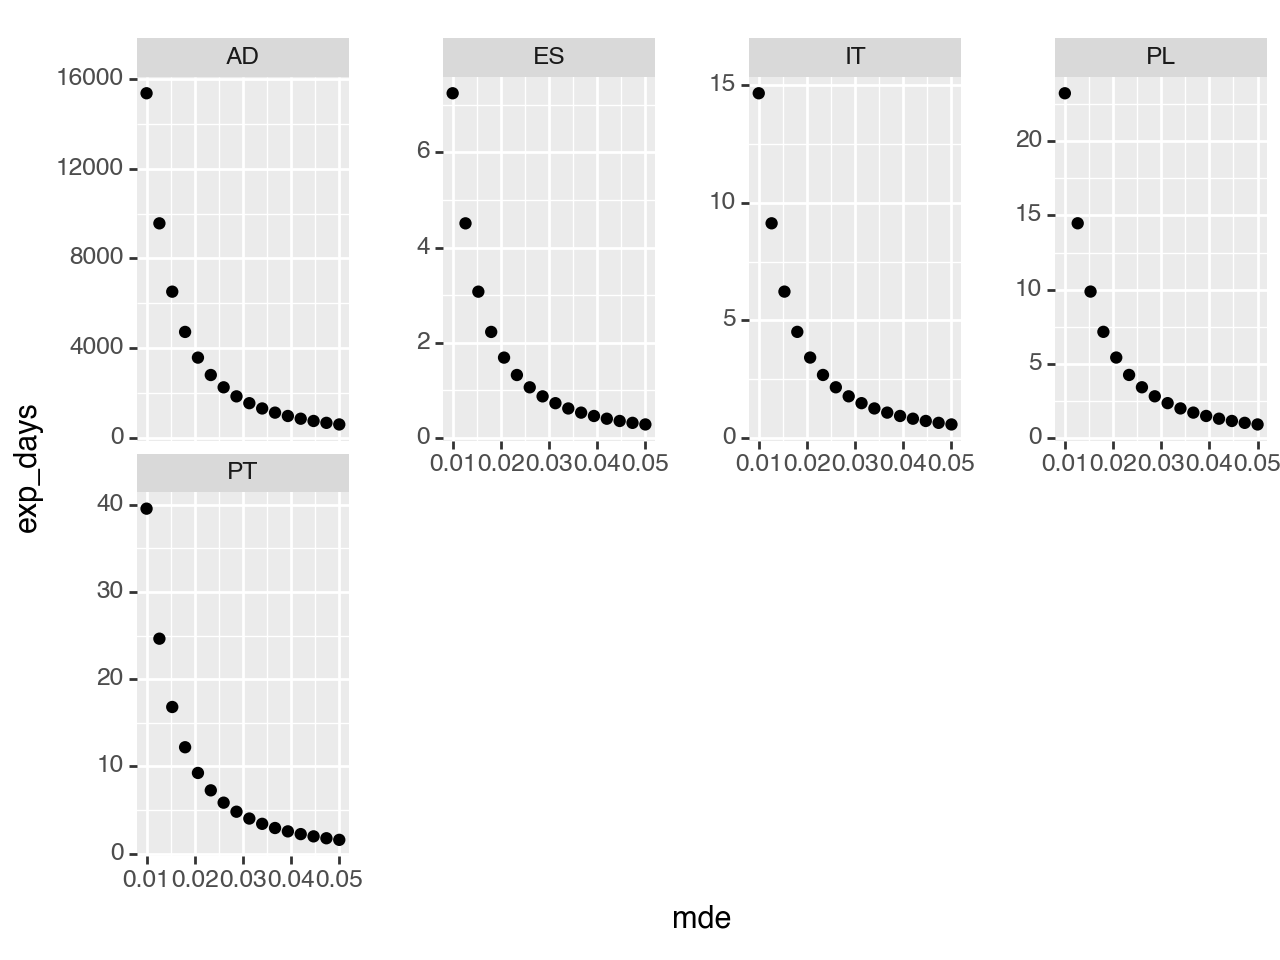

<Figure Size: (640 x 480)>

In [94]:
# Experiment duration plots to detect an MDE
(
    pn.ggplot(exp_design, pn.aes(x='mde', y='exp_days', group='ctr_country')) +
    pn.geom_point() +
    pn.facet_wrap('~ctr_country', scales="free_y", ncol=4) 
    #+
    #pn.theme(figure_size=(15,20))
)

# Now we need to subset to 8% the total traffic we are going to use in real life

In [95]:
import gc

# Now, to delete all DataFrames:
for name in dir():
    if isinstance(globals()[name], pd.DataFrame):
        del globals()[name]

# Call the garbage collector to free up memory
gc.collect()

13507

In [96]:
def sample_daily_events(df, percentage, random_state=None):
    # Ensure the percentage is a float between 0 and 1
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1")
    sampled_df = df.groupby('ctr_date').apply(
        lambda x: x.sample(frac=percentage, replace=False, random_state=random_state))
    sampled_df = sampled_df.reset_index(drop=True)
    return sampled_df

In [97]:
df2=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_40_days.csv') #Downloaded csv data used

In [98]:
sampled_events = sample_daily_events(df2, 0.08, 1)

In [99]:
del df2

In [100]:
df3=pd.read_csv('/Users/juan.inclan/Desktop/DESCARGAS_STARBURST/cvr_20_days.csv') #Downloaded csv data used

In [101]:
sampled_events3= sample_daily_events(df3, 0.08, 1)

In [102]:
del df3

In [103]:
# Join df that were not posible to query due to large amount of information
sampled_events=pd.concat([sampled_events3, sampled_events])

In [104]:
agg2 = sampled_events.groupby(
    ['ctr_date', 'ctr_country'],
    as_index=False
    ).agg(
    count_events = ('coc_dynamic_session_id', 'nunique')
    )

# entries = data[data['pve_first_step'] == 'STARTED']
# How many "STARTS" are done It starts but does not matter where it ends
entries2 = sampled_events.groupby(
    ['ctr_date','ctr_country'], 
    as_index=False
    ).agg(count_starts = ('ctr_dynamic_session_id', 'nunique'))

# Join total starts to their segmentation is total vs individual group that are part of those starts.
agg2 = agg2.merge(entries2, on=['ctr_date','ctr_country'], how='left')

In [105]:
agg2.count_events.sum()/agg2.count_starts.sum()

0.6221893113796613

In [106]:
grouped=agg2.copy()

In [107]:
# Checkout Template screen to Order Created rate confidence intervals
grouped['template_order_rate_lower'], grouped['template_order_rate_upper'] = zip(*grouped.apply(
        lambda x: proportion_confint(x.count_events, x.count_starts),
        axis=1
        )
    )

# PV screen to verified rate
grouped['template_order_rate_rate']=grouped.apply(
        lambda x: x.count_events/x.count_starts,
        axis=1
        )

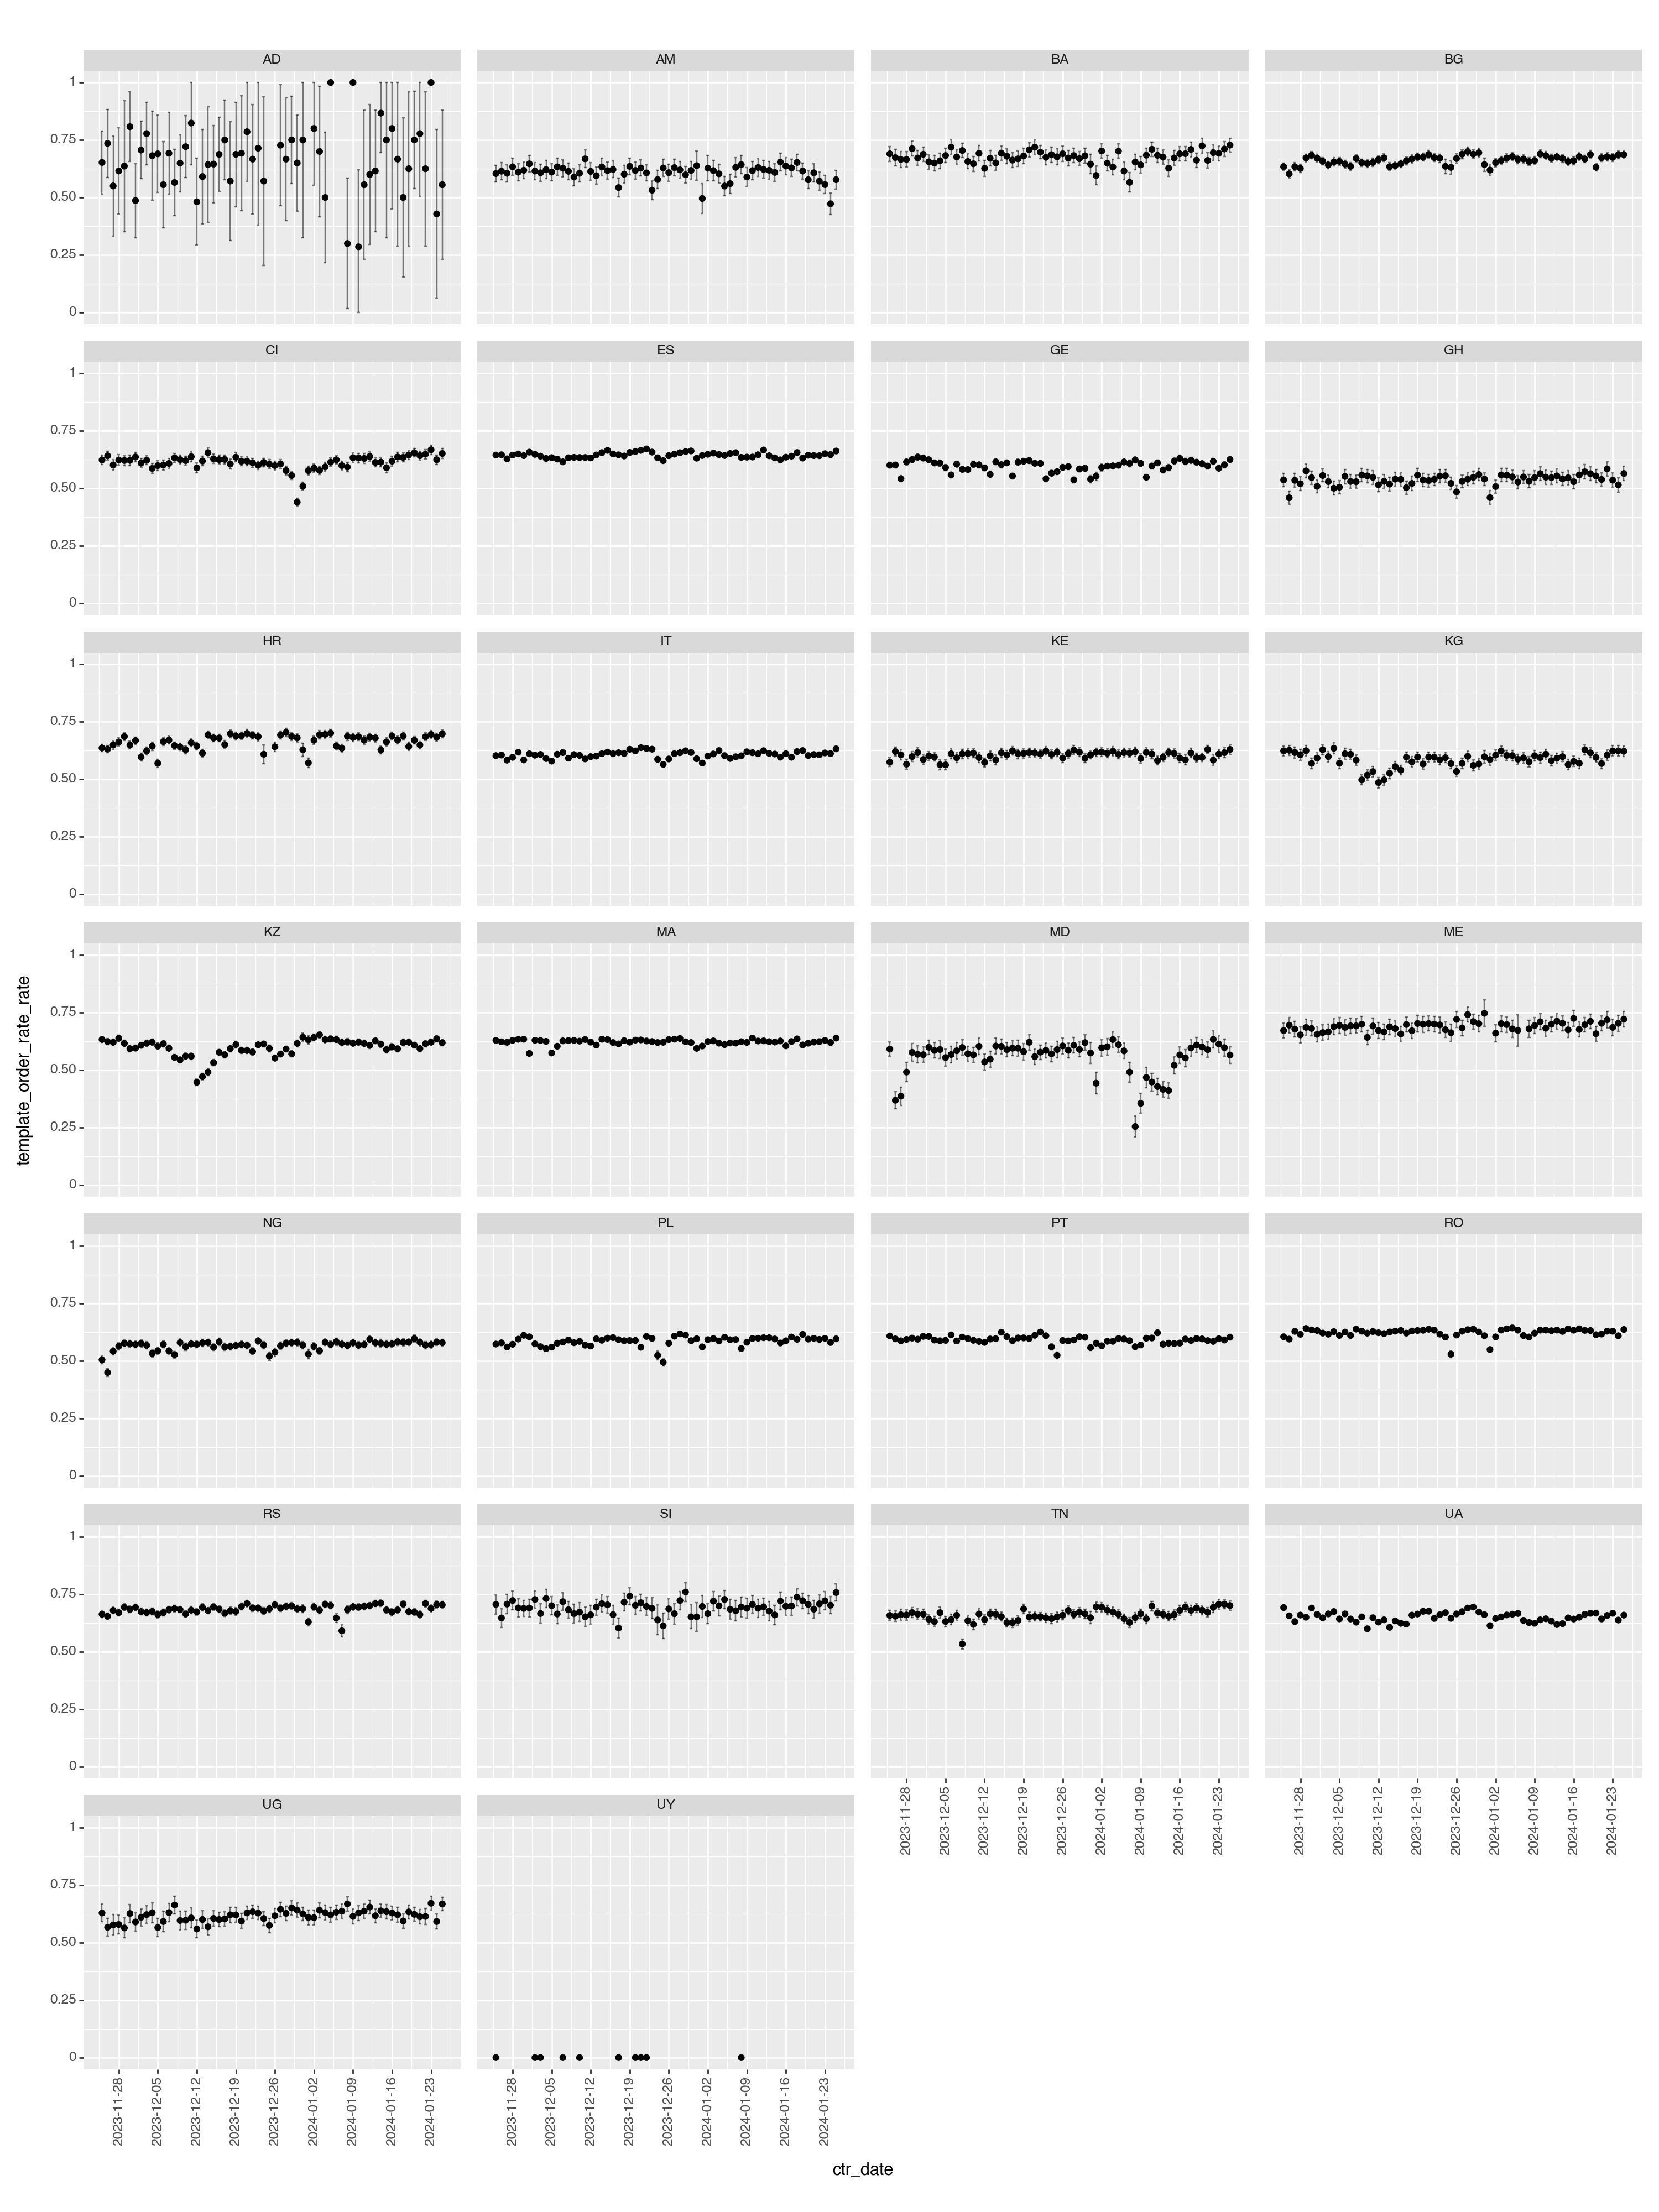

<Figure Size: (1500 x 2000)>

In [108]:
# Historic Checkout Template screen to Order Created rate behaviour
(
    pn.ggplot(grouped, pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

In [109]:
SWE = ['AD', 'ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

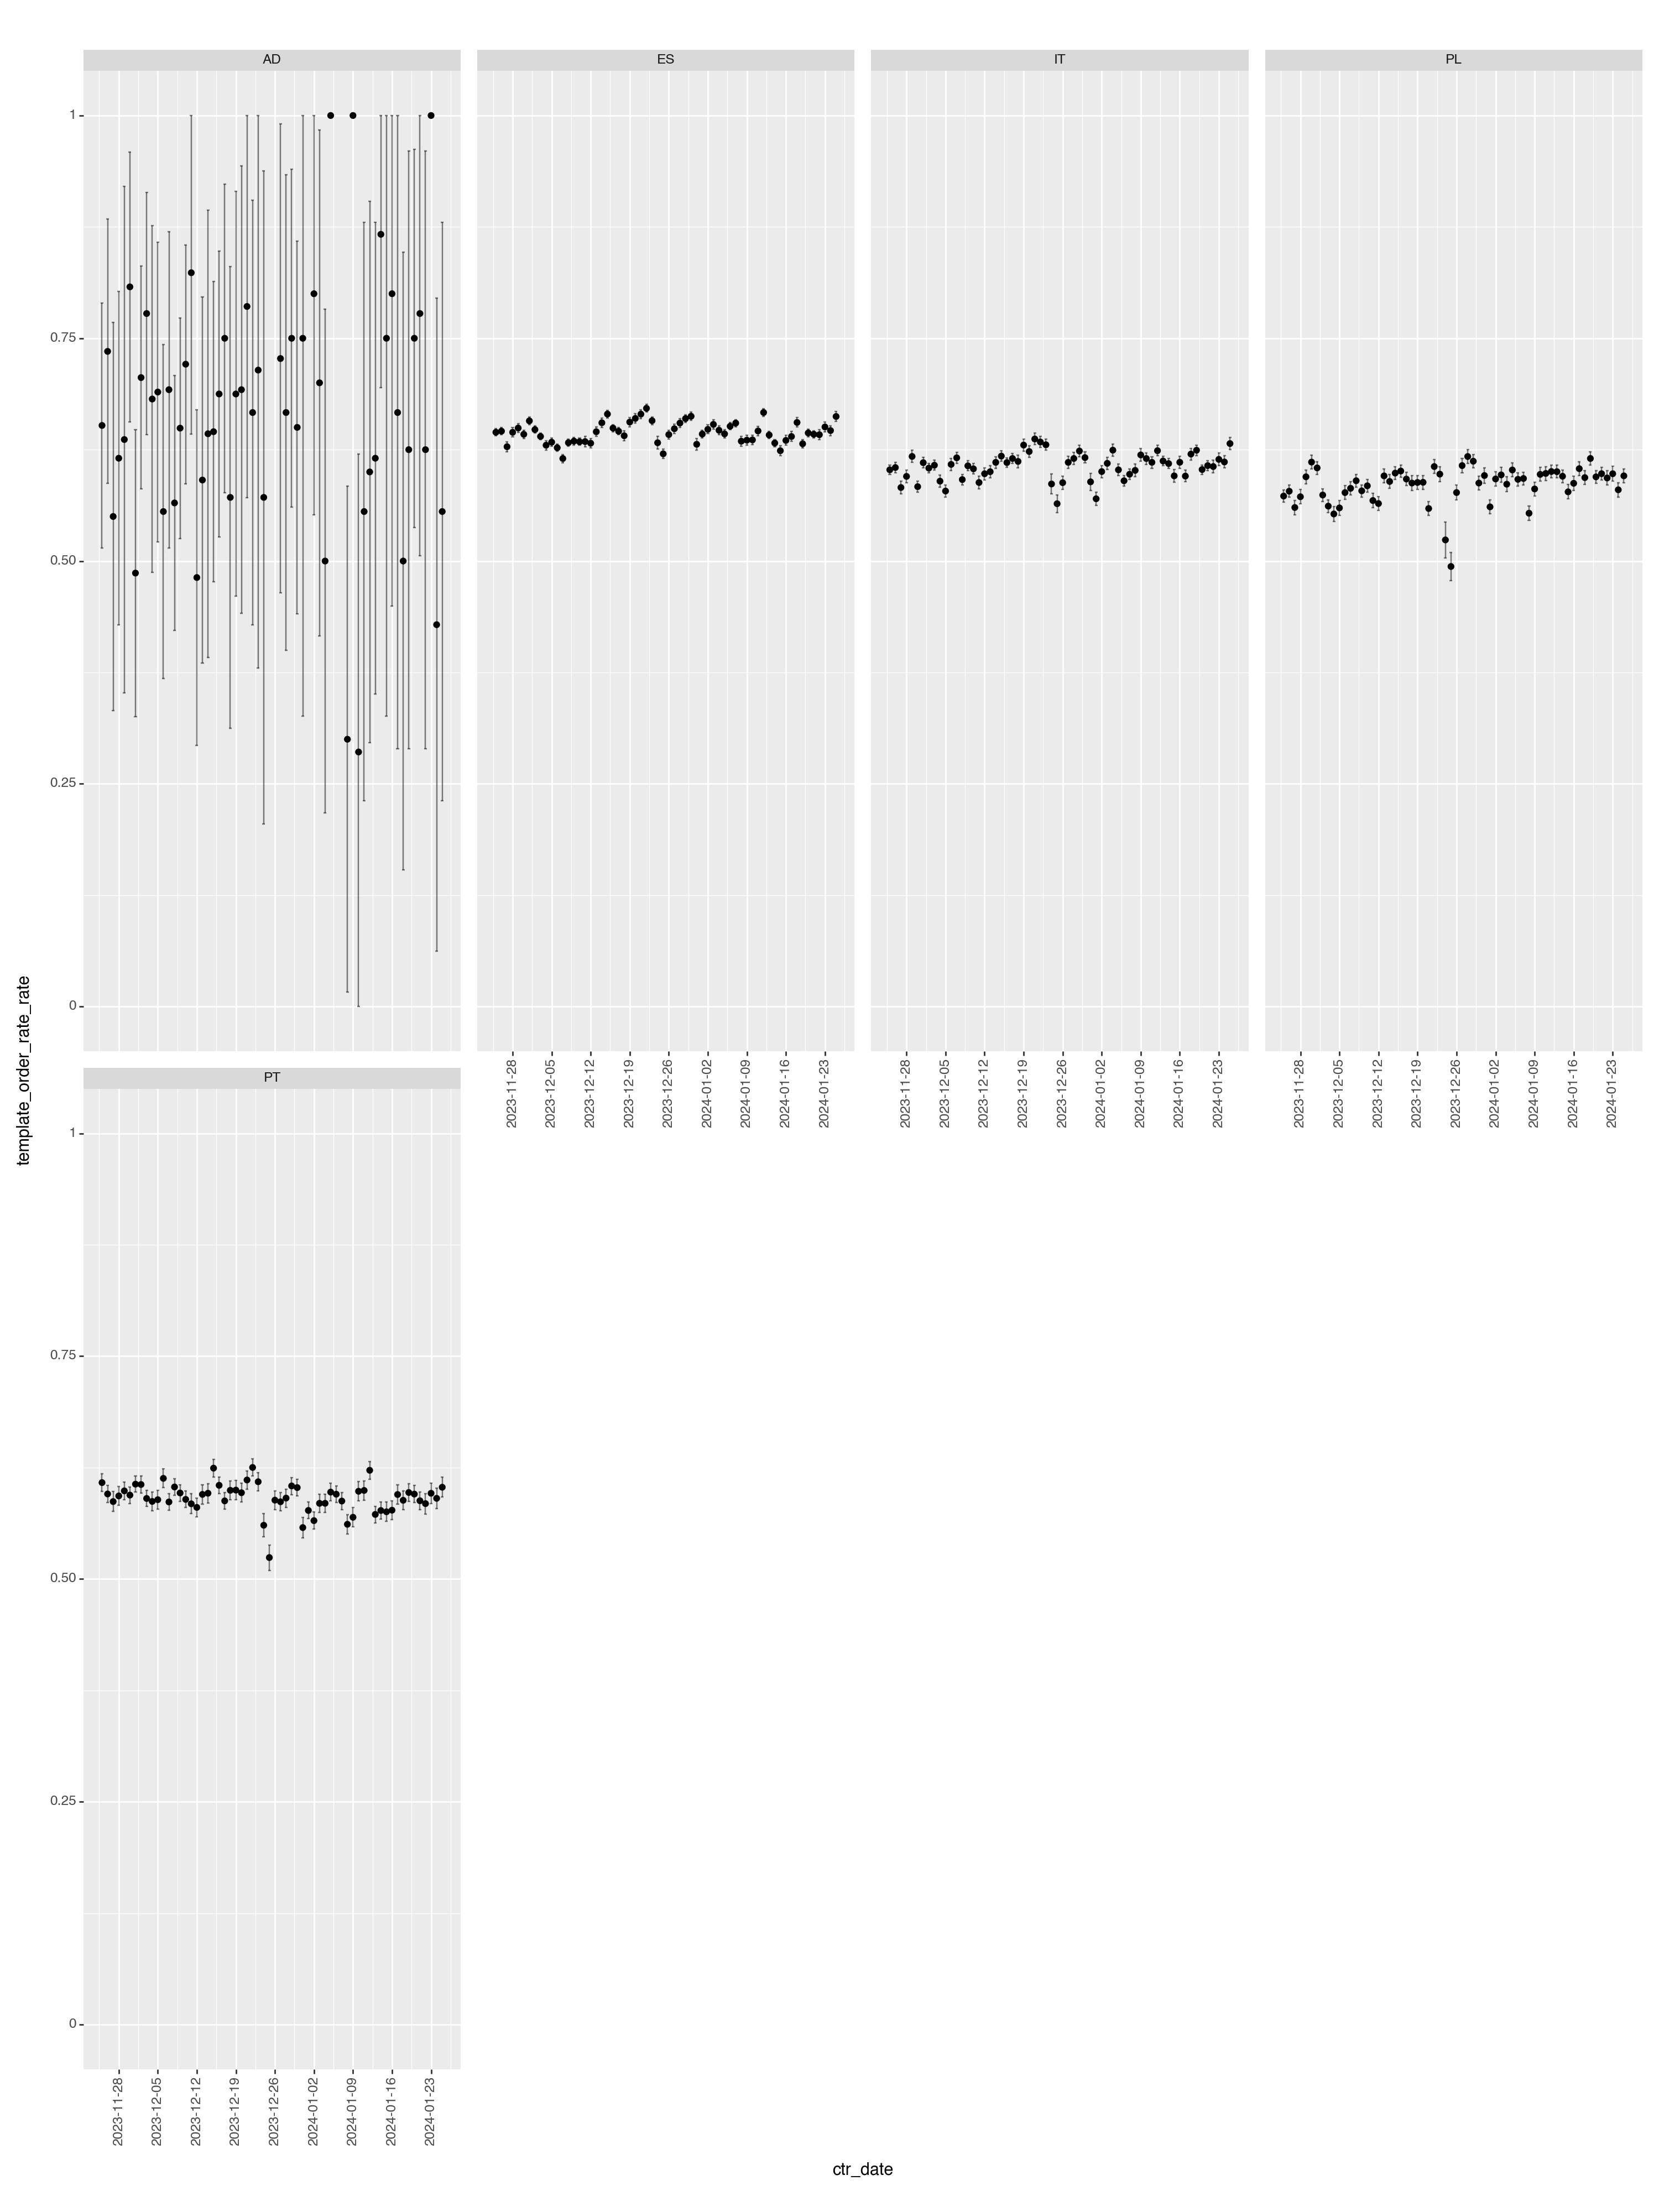

<Figure Size: (1500 x 2000)>

In [110]:
# Historic screen to verified rate behaviour
(
    pn.ggplot(grouped.query(SWE_string), pn.aes(x='ctr_date', y='template_order_rate_rate')) +
    pn.geom_point() +
    pn.geom_errorbar(pn.aes(ymin="template_order_rate_lower",ymax="template_order_rate_upper"), alpha=0.5) +
    pn.scale_x_datetime(breaks=date_breaks('1 weeks')) +
    pn.facet_wrap('~ctr_country', ncol=4) +
    pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(15, 20))
)

# Sample Size

In [111]:
SWE = ['AD','ES', 'IT', 'PL', 'PT']
SWE_string = "ctr_country in @SWE"
#grouped.query(SWE_string)

In [112]:
ALPHA = 0.05 # -> 0.95^2~0.90125 
POWER = 0.80

exp_design = grouped.query(SWE_string).groupby(
    'ctr_country',
    as_index=False
    ).agg(
        total = ("count_starts", "sum"),
        succesful = ("count_events", "sum"),
        avg_daily_events = ("count_starts", "mean")
    )

exp_design['template_order_rate_rate'] = exp_design['succesful']/exp_design['total']

exp_design['template_order_rate_lower'], exp_design['template_order_rate_upper'] = zip(*exp_design.apply(
        lambda x: proportion_confint(x.succesful, x.total),
        axis=1
        )
    )

In [113]:
def cartesian_product(d):
    index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    return pd.DataFrame(index=index).reset_index()

In [114]:
# A range of MDEs (relative increases)
#mdes
mdes = cartesian_product({
    'ctr_country': exp_design['ctr_country'].unique().tolist(),
    'mde':  np.linspace(0.01, 0.05, 16, endpoint=True)
})

In [115]:
exp_design = exp_design.merge(mdes, how='outer')

In [116]:
exp_design['prop_effsize'] = exp_design.apply(
    lambda x: proportion_effectsize((1+x.mde)*x.template_order_rate_rate, x.template_order_rate_rate), 
    axis=1
)

In [117]:
exp_design['ratio'] = 1 #-> 50%-50% split to reduce experiment duration

calc_nobs_var = lambda x: tt_ind_solve_power(
    effect_size=x.prop_effsize, 
    ratio=x.ratio, 
    alpha=ALPHA, 
    power=POWER, 
    alternative='two-sided'
)

exp_design['nobs_CG'] = 1.00*exp_design.apply(calc_nobs_var, axis=1).astype(float)
exp_design['nobs_var'] = exp_design['nobs_CG'] * exp_design['ratio']
exp_design['nobs_total'] = exp_design['nobs_CG'] + exp_design['nobs_var']

In [118]:
exp_design['exp_days'] = exp_design['nobs_total']/exp_design['avg_daily_events']

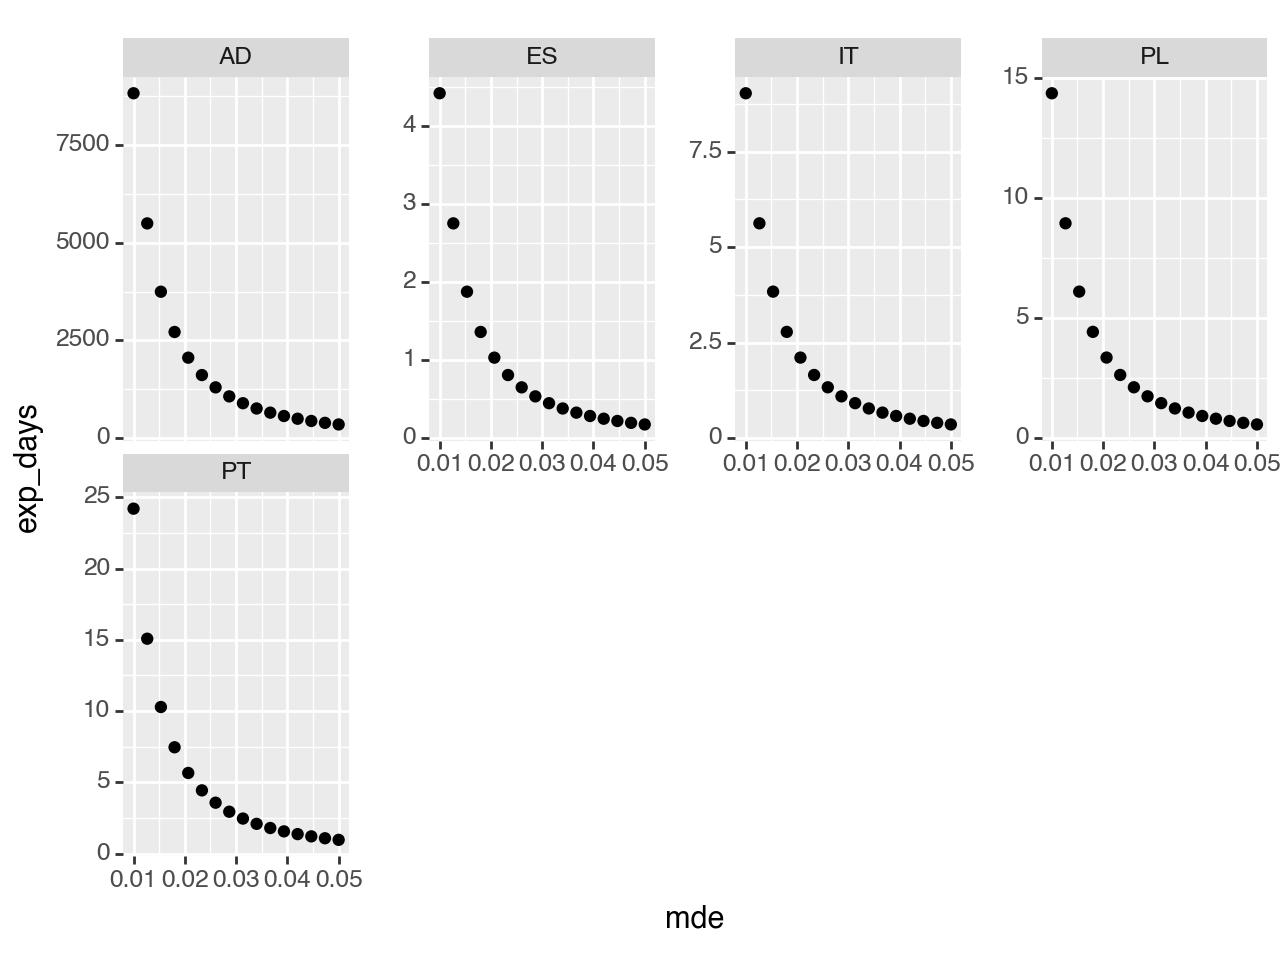

<Figure Size: (640 x 480)>

In [119]:
# Experiment duration plots to detect an MDE
(
    pn.ggplot(exp_design, pn.aes(x='mde', y='exp_days', group='ctr_country')) +
    pn.geom_point() +
    pn.facet_wrap('~ctr_country', scales="free_y", ncol=4) 
    #+
    #pn.theme(figure_size=(15,20))
)